<a href="https://colab.research.google.com/github/fares-ds/machine_learning_in_python_with_scikit_learn/blob/master/magnetic_materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls 'drive/My Drive/magnetic_materials/data/magnetic_materials_featurized.csv'

ls: cannot access 'drive/My Drive/magnetic_materials/data/magnetic_materials_featurized.csv': No such file or directory


In [ ]:
!pip install matminer

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv('drive/My Drive/magnetic_materials/data/magnetic_data_cleaned.csv')
data.head()

,pretty_formula,exchange_symmetry,num_magnetic_sites,num_unique_magnetic_sites,total_magnetization,magnetic_type,total_magnetization_normalized_vol,types_of_magnetic_species,density
0,HPbI3,221,1,1,1.201316,FM,0.004934,['H'],4.016736
1,Li3Ni2(GeO4)3,230,8,1,1.140327,FM,0.005481,['Ni'],4.374443
2,LiMo3P3O13,11,6,3,0.008299,AFM,0.000030,['Mo'],3.573133
3,Sn3H8C2NO7,4,6,7,1.008740,FM,0.003810,['O'],3.224870
4,EuZn(BO2)5,14,4,1,6.000000,FM,0.037478,['Eu'],4.474836


In [6]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.conversions import StrToComposition, CompositionToOxidComposition
from matminer.featurizers import composition as cf

# Add composition-based features
str_to_comp = StrToComposition()
data = str_to_comp.featurize_dataframe(data, 'pretty_formula')

# ele_frac = ElementFraction()
# data = ele_frac.featurize_dataframe(data, 'composition')

features_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"), 
                                           cf.ValenceOrbital(props=['avg', 'frac']), cf.IonProperty(fast=True), 
                                           cf.TMetalFraction()])
feature_labels = features_calculators.feature_labels()

data = features_calculators.featurize_dataframe(data, col_id='composition')
data.head()

,pretty_formula,exchange_symmetry,num_magnetic_sites,num_unique_magnetic_sites,total_magnetization,magnetic_type,total_magnetization_normalized_vol,types_of_magnetic_species,density,composition,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,...,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons,compound possible,max ionic char,avg ionic char,transition metal fraction
0,HPbI3,221,1,1,1.201316,FM,0.004934,['H'],4.016736,"(H, Pb, I)",3,0.663325,0.614463,0.600984,0.600078,0.600002,1.0,82.0,81.0,48.400000,18.960000,53.0,81.0,96.0,15.0,92.200000,4.560000,96.0,1.00794,207.200,206.19206,117.784270,46.710532,126.90447,14.01,600.61,586.60,355.034000,136.409600,386.85,...,3.0,1.600000,0.960000,1.0,6.6150,43.015000,36.400000,32.754000,12.313200,43.015,0.0,7.853,7.853,2.207800,2.258080,1.062,0.0,0.000000,0.000000,0.000000,0.000000,0.0,64.0,225.0,161.0,122.200000,69.840000,64.0,1.800000,3.400000,8.000000,2.800000,0.112500,0.212500,0.500000,0.175000,True,0.051525,0.009575,0.00
1,Li3Ni2(GeO4)3,230,8,1,1.140327,FM,0.005481,['Ni'],4.374443,"(Li, Ni, Ge, O)",4,0.644205,0.607092,0.600250,0.600011,0.600000,3.0,32.0,29.0,12.850000,8.775000,8.0,1.0,87.0,86.0,70.300000,22.650000,87.0,6.94100,72.640,65.69900,27.406130,19.827615,15.99940,54.80,1728.00,1673.20,455.443500,481.298250,54.80,...,3.0,2.150000,0.555000,2.0,9.1050,23.005000,13.900000,12.434750,4.418650,9.105,0.0,0.383,0.383,0.057450,0.097665,0.000,0.0,0.595395,0.595395,0.059539,0.107171,0.0,12.0,229.0,217.0,97.800000,102.960000,12.0,1.850000,2.700000,2.300000,0.000000,0.270073,0.394161,0.335766,0.000000,False,0.779730,0.140974,0.10
2,LiMo3P3O13,11,6,3,0.008299,AFM,0.000030,['Mo'],3.573133,"(Li, Mo, P, O)",4,0.685565,0.655379,0.650170,0.650006,0.650000,3.0,42.0,39.0,13.900000,8.760000,8.0,1.0,87.0,86.0,76.550000,15.520000,87.0,6.94100,95.960,89.01900,29.786724,20.208094,15.99940,54.80,2896.00,2841.20,540.299500,706.710150,54.80,...,5.0,2.700000,1.080000,2.0,9.1050,22.570238,13.465238,12.486952,4.396538,9.105,0.0,1.625,1.625,0.243750,0.414375,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.0,229.0,227.0,53.900000,70.040000,12.0,1.800000,3.050000,0.750000,0.000000,0.321429,0.544643,0.133929,0.000000,False,0.779730,0.094146,0.15
3,Sn3H8C2NO7,4,6,7,1.008740,FM,0.003810,['O'],3.224870,"(Sn, H, C, N, O)",5,0.536639,0.458219,0.414301,0.399458,0.389956,1.0,50.0,49.0,11.095238

In [ ]:
comp_to_oxid_comp = CompositionToOxidComposition()
data = comp_to_oxid_comp.featurize_dataframe(data, 'composition')

oxid_state = cf.OxidationStates()
data = oxid_state.featurize_dataframe(data, 'composition_oxid')

In [ ]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")


data = pd.read_csv('drive/My Drive/magnetic_materials/data/magnetic_materials_featurized.csv')
print('================Data inforamtion=================')
print(data.info())
del_col = ['total_magnetization', 'magmoms', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'exchange_symmetry',
           'magnetic_type', 'total_magnetization_normalized_formula_units', 'total_magnetization_normalized_vol',
           'types_of_magnetic_species', 'density', 'composition', 'composition_oxid']

print(f"Removing those columns: {del_col}")
data.drop(del_col, axis=1, inplace=True)

# Convert int64 to int8 to reduce memory used by the data
int_col = [col for col in data.columns if data[col].dtypes == 'int64']
data[int_col] = data[int_col].astype('int8')

float_col = [col for col in data.columns if data[col].dtypes == 'float64']
data[float_col] = data[float_col].astype('float32')
print('================Data inforamtion=================')
print(data.info())

print('\n====================================================')
print("Splitting the data into Training and Testing........")
formula = data['pretty_formula']
X = data.drop(['pretty_formula', 'ordering'], axis=1)
y = data['ordering']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train Target variable distribution:\n {y_train.value_counts(normalize=True)}\n{y_train.value_counts()}")
print(f"Test Target variable distribution:\n {y_test.value_counts(normalize=True)}\n{y_test.value_counts()}")

# scalar = StandardScaler()
# X_train = scalar.fit_transform(X_train)
# X_test = scalar.transform(X_test)

================Data inforamtion=================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33796 entries, 0 to 33795
Columns: 254 entries, pretty_formula to transition metal fraction
dtypes: float64(223), int64(24), object(7)
memory usage: 65.5+ MB
None
Removing those columns: ['total_magnetization', 'magmoms', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'exchange_symmetry', 'magnetic_type', 'total_magnetization_normalized_formula_units', 'total_magnetization_normalized_vol', 'types_of_magnetic_species', 'density', 'composition', 'composition_oxid']
================Data inforamtion=================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33796 entries, 0 to 33795
Columns: 242 entries, pretty_formula to transition metal fraction
dtypes: float32(219), int8(21), object(2)
memory usage: 29.4+ MB
None

Splitting the data into Training and Testing........
Train Target variable distribution:
 FM     0.714630
FiM    0.229488
AFM    0.055882
Name: ordering, dtype: floa


==============RANDOM FOREST=======================
====================Grid Search: Beginning============================
Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 72.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 95.3min finished


====================Grid Search: Ending============================

Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
TRAINIG RESULTS: 
CONFUSION MATRIX:
[[ 1204   113     5]
 [    0 16905     1]
 [    0   228  5201]]
ACCURACY SCORE:
0.9853
CLASSIFICATION REPORT:
                   AFM            FM  ...     macro avg  weighted avg
precision     1.000000      0.980227  ...      0.993025      0.985605
recall        0.910741      0.999941  ...      0.956228      0.985332
f1-score      0.953286      0.989986  ...      0.973757      0.985184
support    1322.000000  16906.000000  ...  23657.000000  23657.000000

[4 rows x 6 columns]
TESTING RESULTS: 
CONFUSION MATRIX:
[[  97  439   31]
 [  68 6676  502]
 [  31 1492  803]]
ACCURACY SCORE:
0.7472
CLASSIFICATION REPORT:
                  AFM           FM  ...     macro avg  weighted avg
precision    0.494898     0.775648  ...      0.623865      0.

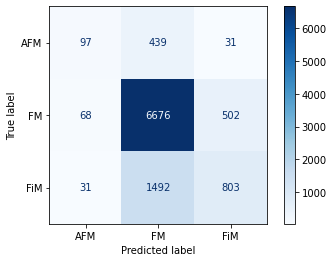

In [ ]:
print("\n==============RANDOM FOREST=======================")
n_estimators = [200]
max_features = ['auto', 'sqrt']
max_depth = [10, 15, 20]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10, 20]
bootstrap = [True, False]

params_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf, 
    'bootstrap': bootstrap
    }

print('====================Grid Search: Beginning============================')
rf_clf = RandomForestClassifier(random_state=42)

rf_cv = GridSearchCV(rf_clf, params_grid, scoring="f1_macro", cv=3, verbose=5, n_jobs=-1)

rf_cv.fit(X_train, y_train)
print('====================Grid Search: Ending============================')

best_params = rf_cv.best_params_
print(f"\n===============================================\nBest parameters: {best_params}")
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

evaluate(rf_clf, X_train, X_test, y_train, y_test)

disp = plot_confusion_matrix(rf_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['AFM', 'FM', 'FiM'])

In [ ]:
'hello'

In [ ]:
print("\n============XGBOOST===============")
n_estimators = [1500, 2000]
learning_rate = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
max_depth = [2, 3, 5, 10, 15]
booster = ['gbtree', 'gblinear']
base_score = [0.25, 0.5, 0.75, 0.99]
min_child_weight = [1, 2, 3, 4]

params_grid = {
    'n_estimators': n_estimators, 
    'learning_rate' : learning_rate, 
#     'max_depth': max_depth,
#     'min_child_weight' : min_child_weight, 
#     'booster' : booster, 
#     'base_score' : base_score
}

xgb_clf = XGBClassifier()
print('====================Grid Search: Beginning============================')
xgb_cv = GridSearchCV(xgb_clf, params_grid, cv=3, scoring = 'f1_macro', n_jobs =-1, verbose=1)
xgb_cv.fit(X_train, y_train)
print('====================Grid Search: Ending============================')

best_params = xgb_cv.best_params_
print(f"Best paramters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

evaluate(xgb_clf, X_train, X_test, y_train, y_test)
evaluate(xgb_clf, X_train, X_test, y_train, y_test)
disp = plot_confusion_matrix(xgb_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['AFM', 'FM', 'FiM'])


============XGBOOST===============
====================Grid Search: Beginning============================
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



============Support Vector Machine===============
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 91.5min finished


Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
TRAINIG RESULTS: 
CONFUSION MATRIX:
[[  398   862    62]
 [   23 16543   340]
 [   22  2247  3160]]
ACCURACY SCORE:
0.8497
CLASSIFICATION REPORT:
                   AFM            FM  ...     macro avg  weighted avg
precision     0.898420      0.841797  ...      0.875786      0.855368
recall        0.301059      0.978528  ...      0.620549      0.849685
f1-score      0.450992      0.905028  ...      0.686315      0.833275
support    1322.000000  16906.000000  ...  23657.000000  23657.000000

[4 rows x 6 columns]
TESTING RESULTS: 
CONFUSION MATRIX:
[[  64  471   32]
 [  89 6561  596]
 [  20 1535  771]]
ACCURACY SCORE:
0.7295
CLASSIFICATION REPORT:
                  AFM           FM  ...     macro avg  weighted avg
precision    0.369942     0.765846  ...      0.562299      0.694442
recall       0.112875     0.905465  ...      0.449937      0.729460
f1-score     0.172973     0.829824  ...      0.472252      0.697687
support    567.000

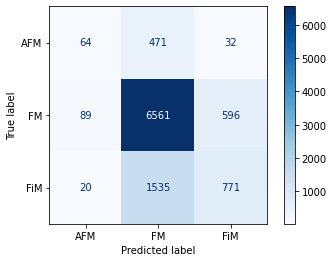

In [ ]:
print("\n============Support Vector Machine===============")
svm_clf = SVC()
params = {"C":(0.1, 1, 10), 
          "gamma":(0.01, 0.1, 1), 
          "kernel":('rbf',)}

svm_cv = GridSearchCV(svm_clf, params, n_jobs=-1, cv=3, verbose=4, scoring="f1_macro")
svm_cv.fit(X_train, y_train)
best_params = svm_cv.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
svm_clf.fit(X_train, y_train)

evaluate(svm_clf, X_train, X_test, y_train, y_test)

disp = plot_confusion_matrix(svm_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['AFM', 'FM', 'FiM'])